In [11]:
from statistics import correlation

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

conn = psycopg2.connect(
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)

In [12]:
query = """
SELECT ticker, date, adj_close
FROM daily_prices
ORDER BY ticker, date
"""

prices = pd.read_sql(query, conn, parse_dates=["date"])
print(f"Loaded {len(prices)} price records for {prices['ticker'].nunique()} tickers")

Loaded 125650 price records for 100 tickers


/var/folders/4d/xhxv9bj17jlcmhb9y9x4_rnh0000gn/T/ipykernel_5885/3109948004.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prices = pd.read_sql(query, conn, parse_dates=["date"])


In [13]:
# Pivot to wide format (tickers as columns, dates as rows)
price_pivot = prices.pivot(index="date", columns="ticker", values="adj_close")
print(price_pivot.head())

ticker             A  AAPL     ABBV  ABNB       ABT  ACGL       ACN    ADBE  \
date                                                                          
2021-02-08  119.2697   NaN  88.2348   NaN  113.6309   NaN  240.3200  493.76   
2021-02-09  119.1054   NaN  87.0455   NaN  114.2241   NaN  240.6656  496.05   
2021-02-10  120.8837   NaN  85.9306   NaN  114.3519   NaN  239.9744  492.67   
2021-02-11  122.7006   NaN  85.6829   NaN  115.7666   NaN  241.8704  496.62   
2021-02-12  123.6864   NaN  86.2527   NaN  117.0352   NaN  240.4694  498.84   

ticker      ADI  ADM  ...  GOOG  GOOGL  KMX  LNT       MMM  MO  SCHW   T  \
date                  ...                                                  
2021-02-08  NaN  NaN  ...   NaN    NaN  NaN  NaN  125.7047 NaN   NaN NaN   
2021-02-09  NaN  NaN  ...   NaN    NaN  NaN  NaN  125.8298 NaN   NaN NaN   
2021-02-10  NaN  NaN  ...   NaN    NaN  NaN  NaN  125.9272 NaN   NaN NaN   
2021-02-11  NaN  NaN  ...   NaN    NaN  NaN  NaN  124.2515 NaN   N

In [14]:
# Calculate 20-day momentum (alpha factor)
# Momentum = (Price today / Price 20 days ago) - 1
momentum_20d = price_pivot.pct_change(periods=20)
print("\nMomentum 20d")
print(momentum_20d.tail())


Momentum 20d
ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
date                                                                     
2026-02-09 -0.141530  0.059787  0.022611 -0.128958 -0.113464  0.009246   
2026-02-10 -0.128319  0.052588  0.019041 -0.131326 -0.094602  0.049442   
2026-02-11 -0.119054  0.056341  0.008685 -0.146498 -0.081533  0.086372   
2026-02-12 -0.144189  0.007751  0.033532 -0.126741 -0.103723  0.093767   
2026-02-13 -0.131326 -0.008484  0.076644 -0.084842 -0.087833  0.081812   

ticker           ACN      ADBE       ADI       ADM  ...      GOOG     GOOGL  \
date                                                ...                       
2026-02-09 -0.156447 -0.200779  0.073240  0.087343  ... -0.014401 -0.012935   
2026-02-10 -0.142725 -0.192217  0.106513  0.103215  ... -0.042377 -0.040017   
2026-02-11 -0.167522 -0.170264  0.137706  0.093405  ... -0.074607 -0.074441   
2026-02-12 -0.230436 -0.137761  0.111984  0.075851  ... -0.080105 -0.079

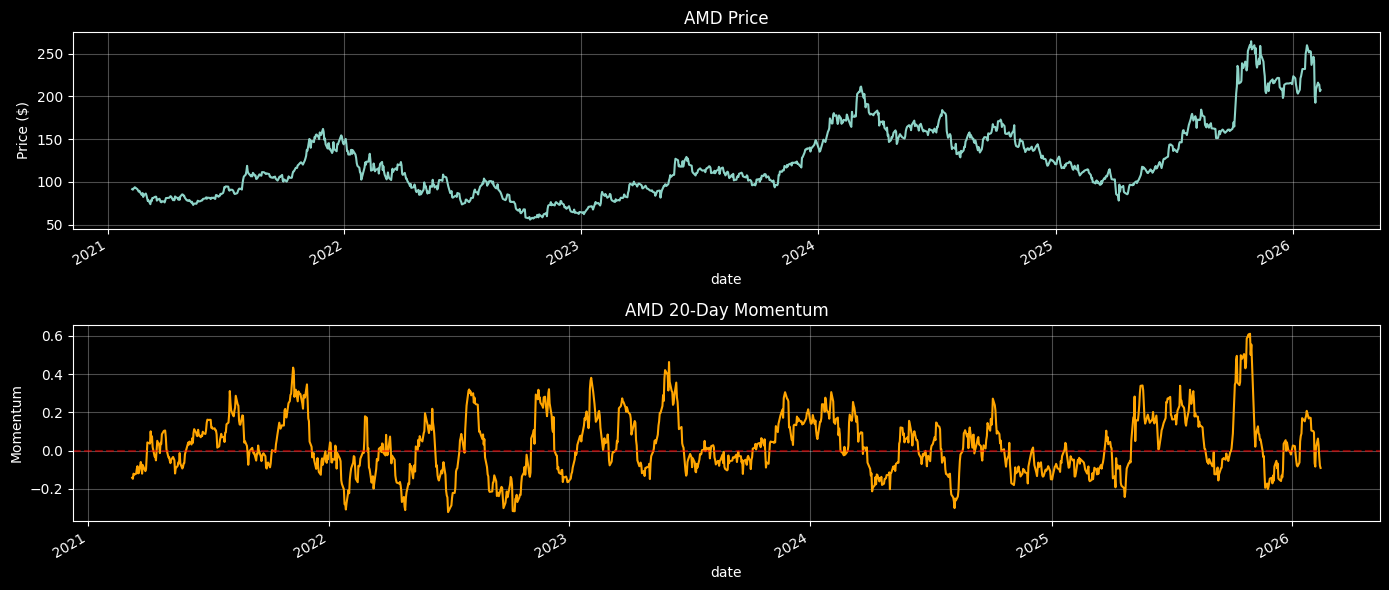

In [15]:
# Visualize momentum for one stock
plt.figure(figsize=(14, 6))

# Plot 1: Price
plt.subplot(2, 1, 1)
price_pivot['AMD'].plot(title="AMD Price")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)

# Plot 2: Momentum
plt.subplot(2, 1, 2)
momentum_20d['AMD'].plot(title="AMD 20-Day Momentum", color="orange")
plt.ylabel("Momentum")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Cross-section analysis - which stocks have the highest momentum today?
latest_date = momentum_20d.index[-1]
latest_momentum = momentum_20d.loc[latest_date].dropna()

print(f"All momentum values on {latest_date}:")
print(latest_momentum.sort_values(ascending=False))

print(f"\nMomentum statistics:")
print(f"Min: {latest_momentum.min():.2%}")
print(f"Max: {latest_momentum.max():.2%}")
print(f"Mean: {latest_momentum.mean():.2%}")

print(f"\nTop 5 HIGHEST momentum stocks (best performers):")
for ticker, momentum in latest_momentum.sort_values(ascending=False).head(5).items():
    print(f"  {ticker}: {momentum:.2%}")

print(f"\nTop 5 LOWEST momentum stocks (worst performers):")
for ticker, momentum in latest_momentum.sort_values(ascending=True).head(5).items():
    print(f"  {ticker}: {momentum:.2%}")

All momentum values on 2026-02-13 00:00:00:
ticker
CHTR    0.228560
AKAM    0.221020
T       0.209018
BALL    0.203972
CAT     0.199066
          ...   
ACN    -0.220801
XYZ    -0.232902
CRL    -0.277979
CZR    -0.284418
AXON   -0.325680
Name: 2026-02-13 00:00:00, Length: 100, dtype: float64

Momentum statistics:
Min: -32.57%
Max: 22.86%
Mean: -0.82%

Top 5 HIGHEST momentum stocks (best performers):
  CHTR: 22.86%
  AKAM: 22.10%
  T: 20.90%
  BALL: 20.40%
  CAT: 19.91%

Top 5 LOWEST momentum stocks (worst performers):
  AXON: -32.57%
  CZR: -28.44%
  CRL: -27.80%
  XYZ: -23.29%
  ACN: -22.08%


In [17]:
# Simple long-short signal
# Long top 3, short bottom 3
latest_momentum_sorted = latest_momentum.sort_values(ascending=False)

top_3 = latest_momentum_sorted.head(3)
bottom_3 = latest_momentum_sorted.tail(3)

print("LONG positions (high momentum)")
for ticker, momentum in top_3.items():
    print(f"  {ticker}: {momentum:+.2%}")

print("SHORT positions (low momentum)")
for ticker, momentum in bottom_3.items():
    print(f"  {ticker}: {momentum:+.2%}")

LONG positions (high momentum)
  CHTR: +22.86%
  AKAM: +22.10%
  T: +20.90%
SHORT positions (low momentum)
  CRL: -27.80%
  CZR: -28.44%
  AXON: -32.57%


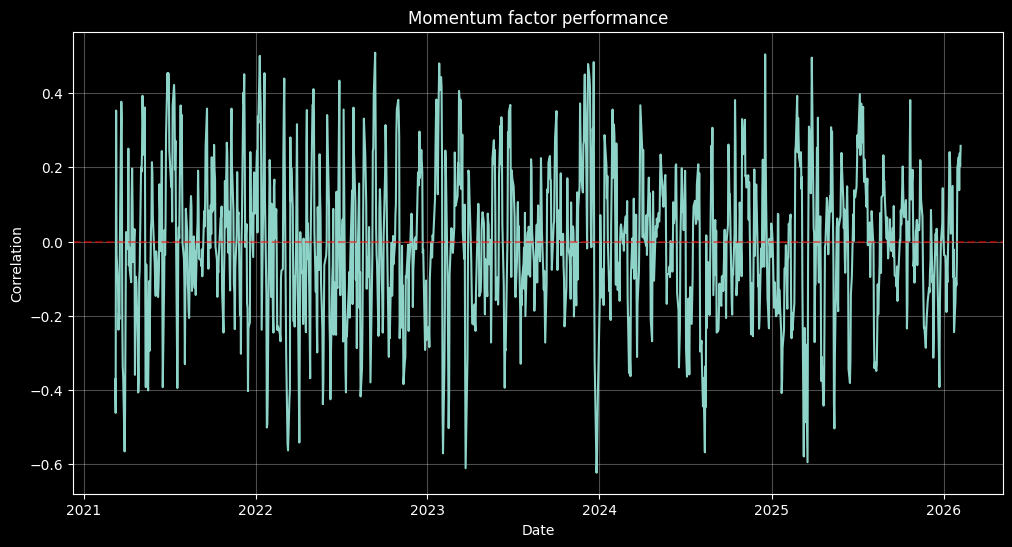


Average correlation: -0.0025


In [18]:
# Simple performance test
# If we bought high momentum stocks, would we have made money?

# Calculate forward returns (what happens after we see the signal)
forward_returns_5d = price_pivot.pct_change(periods=5).shift(-5)

correlations = []
dates = []

for date in momentum_20d.index[20:-5]:
    mom = momentum_20d.loc[date].dropna()
    fwd_net = forward_returns_5d.loc[date].dropna()

    common_stakes = mom.index.intersection(fwd_net.index)

    if len(common_stakes) > 3:
        corr = mom[common_stakes].corr(fwd_net[common_stakes])
        correlations.append(corr)
        dates.append(date)

plt.figure(figsize=(12, 6))
plt.plot(dates, correlations)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title("Momentum factor performance")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage correlation: {np.mean(correlations):.4f}")

In [19]:
# Calculate Information Coefficient (IC) Statistics

# IC is the correlation between factor values and forward returns
# It measure the predictive power of a factor

ic_series = pd.Series(correlations, index=dates)

# Calculate IC statistics
ic_mean = ic_series.mean()
ic_std = ic_series.std()
ic_ir = ic_mean / ic_std

# Percentage of positive ICs
pct_positive = (ic_series > 0).sum() / len(ic_series)

# Statistical significance
from scipy import stats

# sol = mean * (sqrt(x size) / std)
t_stat = ic_mean / (ic_std / np.sqrt(len(ic_series)))
p_value = stats.t.sf(abs(t_stat), len(ic_series) - 1) * 2

print(f"IC mean: {ic_mean:.4f}")
print(f"IC standard dev: {ic_std:.4f}")
print(f"IC information ratio: {ic_ir:.4f}")
print(f"Positive IC: {pct_positive:.1%}")
print("\nStatistical significance")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

# IC Mean interpretation
if ic_mean > 0.05:
    print(f"IC Mean > 0.05: STRONG FACTOR")
elif ic_mean > 0.02:
    print(f"IC Mean > 0.02: DECENT FACTOR")
elif ic_mean > 0:
    print(f"IC Mean > 0: WEAK POSITIVE SIGNIFICANCE")
else:
    print(f"IC Mean < 0: NO PREDICTIVE POWER")


IC mean: -0.0025
IC standard dev: 0.2060
IC information ratio: -0.0124
Positive IC: 50.2%

Statistical significance
t-statistic: -0.43
p-value: 0.6638
IC Mean < 0: NO PREDICTIVE POWER


In [20]:
# Factor Testing

import itertools

# Test different combinations
lookback_periods = [5, 10, 20, 60, 120, 252]  # 1 week to 1 year
forward_periods = [5, 10, 20, 60]  # Forward return periods

results = []

for lookback, forward in itertools.product(lookback_periods, forward_periods):
    momentum = price_pivot.pct_change(periods=lookback)
    forward_returns = price_pivot.pct_change(periods=forward).shift(-forward)

    correlations = []

    # Need enough data for both lookback and forward
    valid_start = max(lookback, forward)
    valid_end = forward

    for date in momentum.index[valid_start:-valid_end]:
        mom = momentum.loc[date].dropna()
        fwd = forward_returns.loc[date].dropna()
        common = mom.index.intersection(fwd.index)

        if len(common) > 5:  # Need at least 5 stocks
            corr = mom[common].corr(fwd[common])
            if not np.isnan(corr):
                correlations.append(corr)

    if len(correlations) > 100:  # Need meaningful sample
        ic_mean = np.mean(correlations)
        ic_std = np.std(correlations)
        ic_ir = ic_mean / ic_std if ic_std > 0 else 0

        results.append({
            'lookback': lookback,
            'forward': forward,
            'ic_mean': ic_mean,
            'ic_std': ic_std,
            'ic_ir': ic_ir,
            'pct_positive': sum(1 for c in correlations if c > 0) / len(correlations),
            'n_observations': len(correlations)
        })

results_df = pd.DataFrame(results)

# Sort by IC mean
results_df_sorted = results_df.sort_values('ic_mean', ascending=False)

print("=" * 80)
print("TOP 10 PARAMETER COMBINATIONS (by IC Mean)")
print("=" * 80)
print(results_df_sorted.head(10).to_string(index=False))

print("\n" + "=" * 80)
print("TOP 10 PARAMETER COMBINATIONS (by IC Information Ratio)")
print("=" * 80)
results_df_sorted_ir = results_df.sort_values('ic_ir', ascending=False)
print(results_df_sorted_ir.head(10).to_string(index=False))


TOP 10 PARAMETER COMBINATIONS (by IC Mean)
 lookback  forward  ic_mean   ic_std    ic_ir  pct_positive  n_observations
      252       60 0.032246 0.212438 0.151792      0.579557             949
      252       20 0.031448 0.225285 0.139591      0.580384             989
      252       10 0.021151 0.242235 0.087315      0.530531             999
      252        5 0.015919 0.255767 0.062241      0.537849            1004
      120       60 0.008532 0.191211 0.044620      0.501388            1081
       10       20 0.003355 0.193578 0.017332      0.521704            1221
      120       20 0.001245 0.227044 0.005482      0.513827            1121
      120       10 0.000882 0.220975 0.003992      0.510168            1131
        5       20 0.000796 0.197350 0.004031      0.501229            1221
       20       10 0.000747 0.192085 0.003889      0.493907            1231

TOP 10 PARAMETER COMBINATIONS (by IC Information Ratio)
 lookback  forward  ic_mean   ic_std    ic_ir  pct_positive  n_o

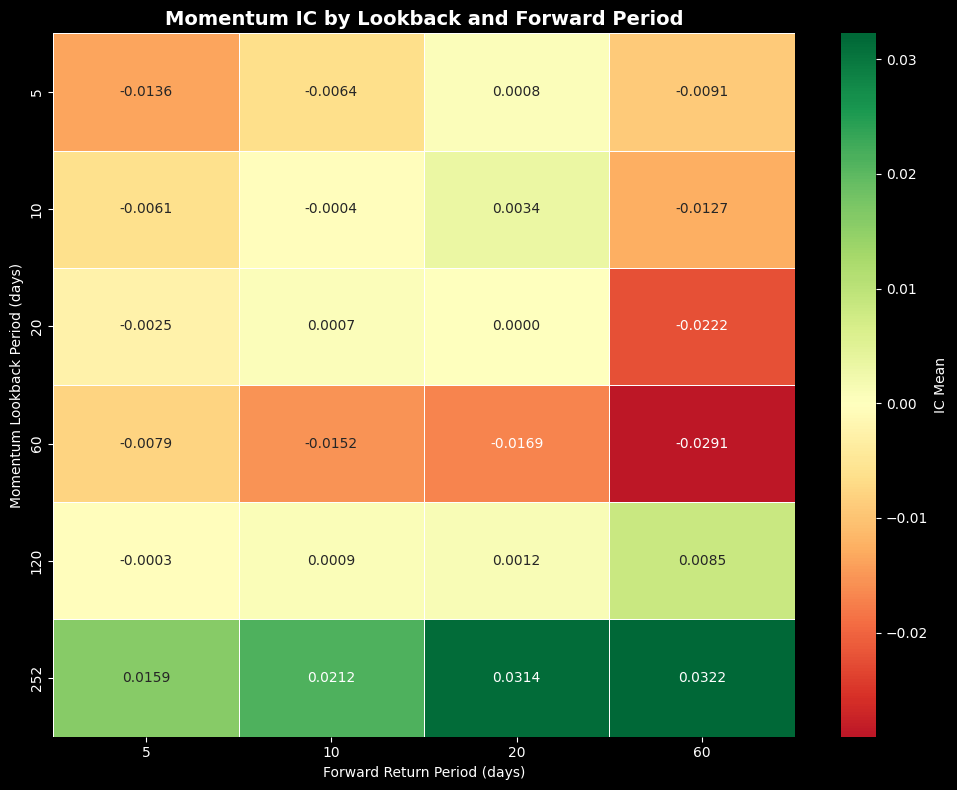

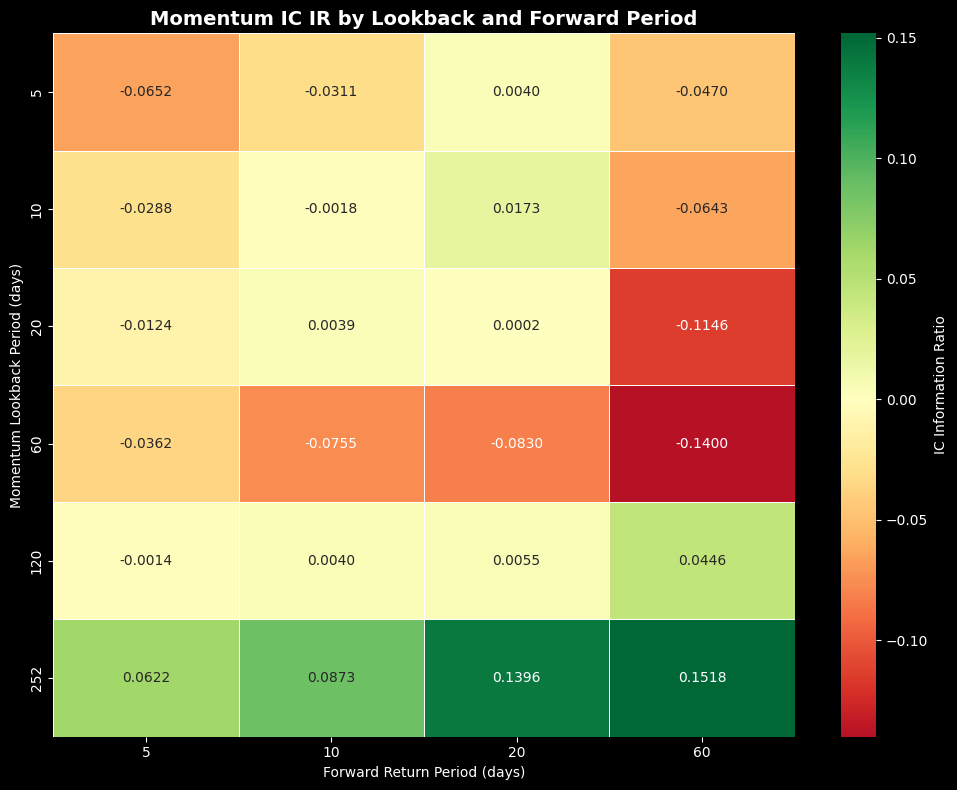

In [21]:
# IC Heatmap

pivot_ic = results_df.pivot(index='lookback', columns='forward', values='ic_mean')

plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(pivot_ic, annot=True, fmt='.4f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'IC Mean'}, linewidths=0.5)
plt.title('Momentum IC by Lookback and Forward Period', fontsize=14, fontweight='bold')
plt.xlabel('Forward Return Period (days)')
plt.ylabel('Momentum Lookback Period (days)')
plt.tight_layout()
plt.show()

# IC IR heatmap
pivot_ic_ir = results_df.pivot(index='lookback', columns='forward', values='ic_ir')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_ic_ir, annot=True, fmt='.4f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'IC Information Ratio'}, linewidths=0.5)
plt.title('Momentum IC IR by Lookback and Forward Period', fontsize=14, fontweight='bold')
plt.xlabel('Forward Return Period (days)')
plt.ylabel('Momentum Lookback Period (days)')
plt.tight_layout()
plt.show()

252-DAY MOMENTUM FACTOR - DETAILED ANALYSIS

IC Mean:              0.0322
IC Std Dev:           0.2126
IC Information Ratio: 0.1517
% Positive ICs:       58.0%

t-statistic:          4.67
p-value:              0.000003
✓ HIGHLY SIGNIFICANT (p < 0.01)


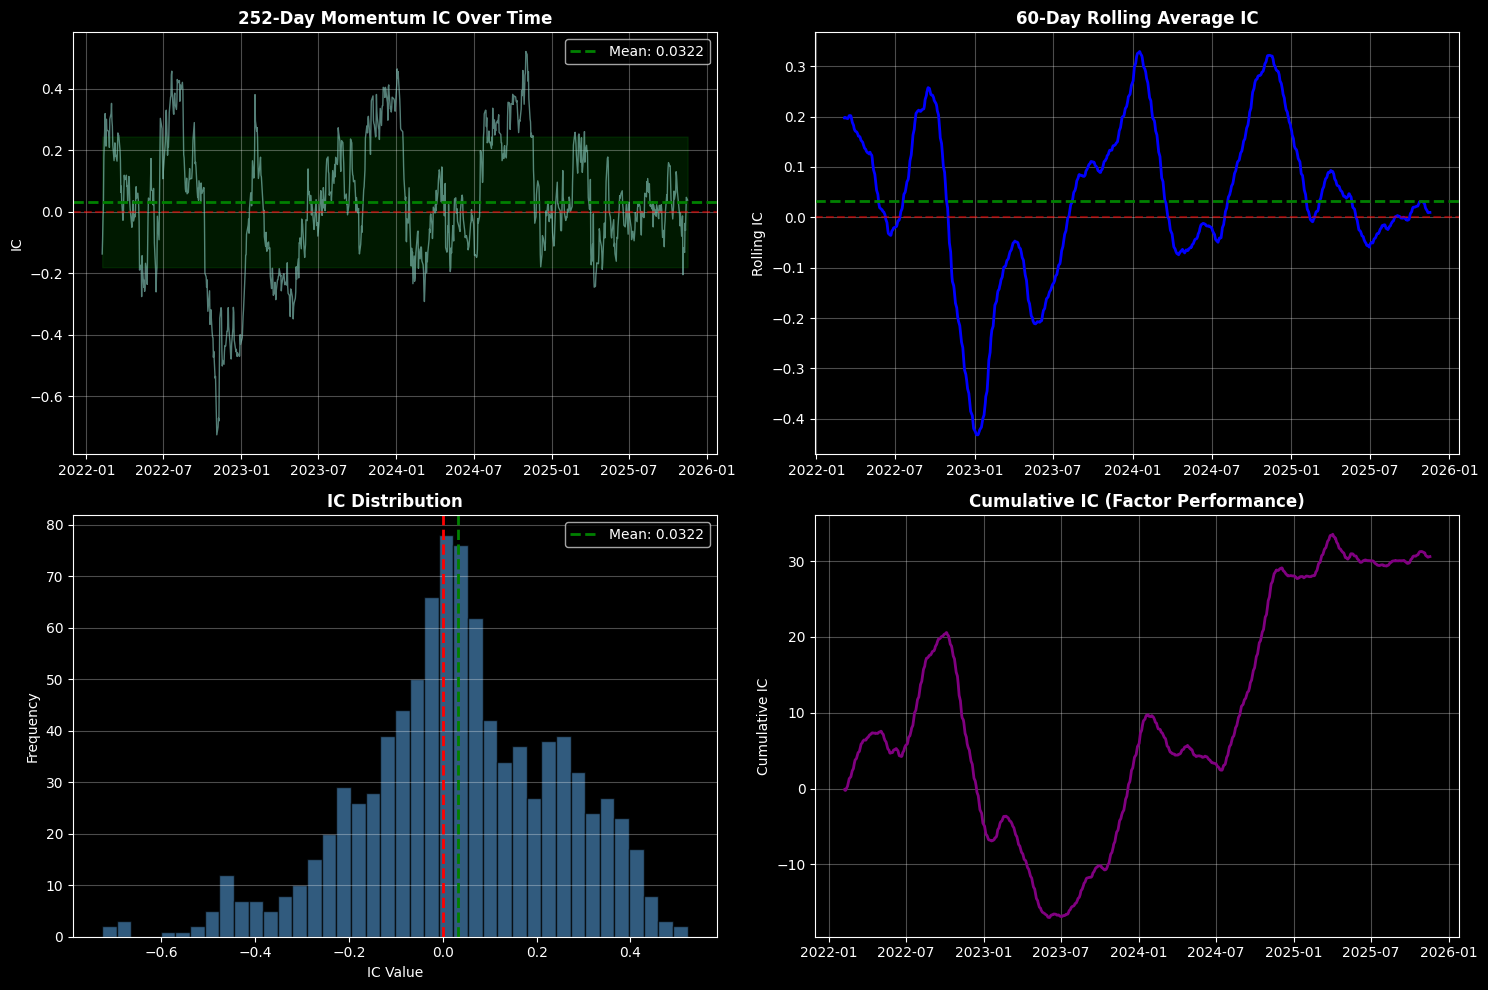

In [22]:

# 252-Day Momentum

lookback = 252
forward = 60

momentum_252 = price_pivot.pct_change(periods=lookback)
forward_returns = price_pivot.pct_change(periods=forward).shift(-forward)

correlations = []
dates = []

for date in momentum_252.index[lookback:-forward]:
    mom = momentum_252.loc[date].dropna()
    fwd = forward_returns.loc[date].dropna()
    common = mom.index.intersection(fwd.index)

    if len(common) > 5:
        corr = mom[common].corr(fwd[common])
        if not np.isnan(corr):
            correlations.append(corr)
            dates.append(date)

ic_series = pd.Series(correlations, index=dates)

# Statistics
ic_mean = ic_series.mean()
ic_std = ic_series.std()
ic_ir = ic_mean / ic_std
pct_positive = (ic_series > 0).sum() / len(ic_series)

# Statistical significance
from scipy import stats
t_stat = ic_mean / (ic_std / np.sqrt(len(ic_series)))
p_value = stats.t.sf(abs(t_stat), len(ic_series)-1) * 2

print("=" * 70)
print("252-DAY MOMENTUM FACTOR - DETAILED ANALYSIS")
print("=" * 70)
print(f"\nIC Mean:              {ic_mean:.4f}")
print(f"IC Std Dev:           {ic_std:.4f}")
print(f"IC Information Ratio: {ic_ir:.4f}")
print(f"% Positive ICs:       {pct_positive:.1%}")
print(f"\nt-statistic:          {t_stat:.2f}")
print(f"p-value:              {p_value:.6f}")

if p_value < 0.01:
    print("HIGHLY SIGNIFICANT (p < 0.01)")
elif p_value < 0.05:
    print("SIGNIFICANT (p < 0.05)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IC over time
axes[0, 0].plot(dates, correlations, alpha=0.6, linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=ic_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {ic_mean:.4f}')
axes[0, 0].fill_between(dates, ic_mean - ic_std, ic_mean + ic_std, alpha=0.2, color='green')
axes[0, 0].set_title('252-Day Momentum IC Over Time', fontweight='bold')
axes[0, 0].set_ylabel('IC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Rolling 60-day IC
ic_rolling = ic_series.rolling(window=60, min_periods=20).mean()
axes[0, 1].plot(ic_rolling.index, ic_rolling.values, color='blue', linewidth=2)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=ic_mean, color='green', linestyle='--', linewidth=2)
axes[0, 1].set_title('60-Day Rolling Average IC', fontweight='bold')
axes[0, 1].set_ylabel('Rolling IC')
axes[0, 1].grid(True, alpha=0.3)

# IC distribution
axes[1, 0].hist(correlations, bins=40, alpha=0.7, edgecolor='black', color='steelblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=ic_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {ic_mean:.4f}')
axes[1, 0].set_title('IC Distribution', fontweight='bold')
axes[1, 0].set_xlabel('IC Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Cumulative IC
ic_cumsum = ic_series.cumsum()
axes[1, 1].plot(ic_cumsum.index, ic_cumsum.values, linewidth=2, color='purple')
axes[1, 1].set_title('Cumulative IC (Factor Performance)', fontweight='bold')
axes[1, 1].set_ylabel('Cumulative IC')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()